<a href="https://colab.research.google.com/github/shihab1h/leaf_image_classification/blob/main/Leaf_Image_Classification_TF_Auto_Model_Selection_USE_ORIGINAL_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
from google.colab import files, drive
import os
import shutil
from PIL import Image
import sys
import glob
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomBrightness, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
!pip install keras_tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.2 MB/s eta 0:00:00


In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
# Delete Unzipped Unempty Directory containing Dataset
# Uncommend Code in case of need (e.g., need intact unzipped dataset)
# shutil.rmtree("./Plants_2")

## Global Variables

In [6]:
# Choose Source of Dataset
DATASET_FROM_SCRATCH = True

# IF True: download, unzip, resize dataset from scratch
# Estimated time on free Colab instance is 20 mins

# IF False: download a saved previously preprocess dataset

In [7]:
# Choose Wether to Save Model and/or Processed Dataset to Drive
SAVE_TO_DRIVE = False 

# IF True:
# Save processed dataset to drive in case of DATASET_FROM_SCRATCH == True
# Save models in any case

# If DATASET_FROM_SCRATCH == False, user still has to mount drive to load preprocessed dataset

In [8]:
# Paths as Folder Structure
paths = ["Plants_2/train", "Plants_2/valid", "Plants_2/test"]
paths = [os.path.join(os.getcwd(), path) for path in paths]

In [9]:
# Data Processing Parameters
PATH_KEYWORD = 'diseased' # Used in del_subdirs()
RESIZE_PIXELS = 512 # Used in resize_images()

In [10]:
IMG_SIZE = 256 # Assumed Square Image IMG_SIZE x IMG_SIZE
SEED = 12345

In [11]:
MAX_TRIALS_TUNER = 10
EPOCHS_TUNER = 10

In [12]:
EPOCHS_FIT = 100

## Functions

In [13]:
# Function to Delete Subdirectories Selectively
def del_subdirs(path, keyword):
  paths_to_delete = [sd for sd in os.listdir(path) if keyword in sd]
  for p2d in paths_to_delete:
    shutil.rmtree(os.path.join(path, p2d))
  return

In [14]:
# Function to Resize Images
def resize_image(img_path):
  img = Image.open(img_path)
  img_resized = img.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
  img_path_resized = img_path[:-4] + "_resized" + img_path[-4:]
  img_resized.save(img_path_resized, 'JPEG', quality=90)
  os.remove(img_path)

In [15]:
# Function to Resize Images
def resize_images(size_pixels):
  i = 0
  for path_subdir in paths:
    for img_path in glob.iglob(path_subdir + '/*/*.JPG', recursive=True):
        img = Image.open(img_path)
        img_resized = img.resize((size_pixels, size_pixels), Image.NEAREST)
        img_path_resized = img_path[:-4] + "_resized" + img_path[-4:]
        img_resized.save(img_path_resized, 'JPEG', quality=90)
        os.remove(img_path)
        clear_output(wait=True)
        i += 1
        display('Images resized: ' + str(i))

In [16]:
# Function to Resize Images
def resize_images(size_pixels):
  i = 0
  for path_subdir in paths:
    for img_path in glob.iglob(path_subdir + '/*/*.JPG', recursive=True):
        img = Image.open(img_path)
        img_resized = img.resize((size_pixels, size_pixels), Image.NEAREST)
        img_path_resized = img_path[:-4] + "_resized" + img_path[-4:]
        img_resized.save(img_path_resized, 'JPEG', quality=90)
        os.remove(img_path)
        clear_output(wait=True)
        i += 1
        display('Images resized: ' + str(i))

In [17]:
# Function to Build Deep Learning Model
def make_model(params):
  # Hyperparameters Search Space
  DROPOUT_CONV = params.Float("dropout_conv", min_value = 0.1, max_value = 0.3, step = 0.1)
  DROPOUT_DENSE = params.Float("dropout_dense", min_value = 0.3, max_value = 0.5, step = 0.1)

  FILTERS_1 = params.Int("CL1_filters", min_value=16, max_value=32, step=8)
  FILTERS_2 = params.Int("+CL2_addl_filters", min_value=16, max_value=32, step=8)
  FILTERS_3 = params.Int("+CL3_addl_filters", min_value=16, max_value=32, step=8)

  UNITS_DENSE = params.Int("units_dense", min_value=8, max_value=32, step=8)
  OPTIMIZER = params.Choice("optimizer", values = ["adam", "sgd"])

  # Build Model
  model = Sequential(
      [
          Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
          RandomFlip("horizontal"),
          RandomFlip("vertical"),
          RandomRotation(0.2),
          RandomBrightness(0.2),
          Rescaling(scale=1/127.5, offset=-1),
          Conv2D(filters=FILTERS_1, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Conv2D(filters=FILTERS_1+FILTERS_2, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Conv2D(filters=FILTERS_1+FILTERS_2+FILTERS_3, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Flatten(),
          Dense(UNITS_DENSE),
          Dropout(DROPOUT_DENSE),
          Dense(NUM_CLASSES),
          Softmax()
      ]
  )

  # Compile Model
  model.compile(optimizer=OPTIMIZER, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model


## Dataset

In [18]:
# Mount Google Drive
# Required either way to save to OR read from the processed dataset
# Requires user permission
if SAVE_TO_DRIVE or not DATASET_FROM_SCRATCH:
  drive.mount('/content/drive')
# If using the preprocessed dataset, must mount Google Drive
# If handling dataset from scratch and saving it and the models is desired

In [19]:
# Prepare Dataset
if DATASET_FROM_SCRATCH:
  # Download Original Dataset and Perform All Preprocessing from Scratch
  print("SELECTED OPTION: Use Original Dataset")
  print("The original dataset approx 8 GB will be downloaded and processed")
  print("This procedure could take about 20 mins on a free Colab instance.")
  print("-----------------------------------------------------------------")

  # Upload Kaggle Credentials JSON File
  print("STEP 1: Upload Kaggle JSON Credintials")
  kaggle_token = files.upload()

  # Set Kaggle Directory Variable to Locate Kaggle Credentials
  os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

  # Download Kaggle Dataset
  print("STEP 2: Download Dataset")
  !kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

  # Unzip Dataset
  print("STEP 3: Unzip Dataset")
  !unzip -q /content/plant-leaves-for-image-classification.zip

  # Delete Diseased Images
  print("STEP 4: Delete Certain Subdirectories")
  for path in paths:
    del_subdirs(path, PATH_KEYWORD)

  # Resize Images
  print("STEP 5: Resize Images")
  resize_images(RESIZE_PIXELS)

  if SAVE_TO_DRIVE:
    # ZIP Processed Dataset
    print("STEP 6: Zip Processed Dataset")
    !zip -r -q /content/Plants_2.zip /content/Plants_2

    # Save Processed Dataset to Google Drive
    print("STEP 7: Save Processed Dataset to Drive")
    shutil.copy("/content/Plants_2.zip","/content/drive/MyDrive/")

else:
  # Use Previously Preprocessed Dataset, to save time
  print("SELECTED OPTION: Use Previously Preprocessed Dataset")
  !unzip -q /content/drive/MyDrive/Plants_2.zip -d /

'Images resized: 2273'

## Model

In [20]:
train_ds = image_dataset_from_directory(paths[0], image_size=(IMG_SIZE, IMG_SIZE)) # Default Batch Size: 32
val_ds = image_dataset_from_directory(paths[1], image_size=(IMG_SIZE, IMG_SIZE))
test_ds = image_dataset_from_directory(paths[2], image_size=(IMG_SIZE, IMG_SIZE), shuffle = False)

Found 2163 files belonging to 11 classes.
Found 55 files belonging to 11 classes.
Found 55 files belonging to 11 classes.


In [21]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
true_test_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(512).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
tuner = kt.RandomSearch(make_model, objective = "val_accuracy", max_trials = MAX_TRIALS_TUNER, directory = "grid_search")
tuner.search(train_ds, validation_data = val_ds, epochs = EPOCHS_TUNER)

Trial 10 Complete [00h 00m 50s]
val_accuracy: 0.4363636374473572

Best val_accuracy So Far: 0.6545454263687134
Total elapsed time: 00h 11m 50s


In [24]:
tuner.results_summary()

Results summary
Results in grid_search/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
dropout_conv: 0.1
dropout_dense: 0.4
CL1_filters: 24
+CL2_addl_filters: 24
+CL3_addl_filters: 16
units_dense: 32
optimizer: adam
Score: 0.6545454263687134

Trial 01 summary
Hyperparameters:
dropout_conv: 0.2
dropout_dense: 0.5
CL1_filters: 32
+CL2_addl_filters: 24
+CL3_addl_filters: 24
units_dense: 24
optimizer: adam
Score: 0.6000000238418579

Trial 06 summary
Hyperparameters:
dropout_conv: 0.2
dropout_dense: 0.3
CL1_filters: 24
+CL2_addl_filters: 32
+CL3_addl_filters: 24
units_dense: 16
optimizer: sgd
Score: 0.581818163394928

Trial 00 summary
Hyperparameters:
dropout_conv: 0.2
dropout_dense: 0.4
CL1_filters: 24
+CL2_addl_filters: 16
+CL3_addl_filters: 16
units_dense: 24
optimizer: sgd
Score: 0.5272727012634277

Trial 02 summary
Hyperparameters:
dropout_conv: 0.2
dropout_dense: 0.5
CL1_filters: 24
+CL2_addl_filters: 24
+CL3_a

In [25]:
best_params = tuner.get_best_hyperparameters()[0]
best_params.get_config()["values"]

{'dropout_conv': 0.1,
 'dropout_dense': 0.4,
 'CL1_filters': 24,
 '+CL2_addl_filters': 24,
 '+CL3_addl_filters': 16,
 'units_dense': 32,
 'optimizer': 'adam'}

In [26]:
model = tuner.hypermodel.build(best_params)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_brightness_1 (Random  (None, 256, 256, 3)      0         
 Brightness)                                                     
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 24)     

In [28]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=50)

In [29]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FIT, callbacks=[earlystop])


Epoch 1/100
68/68 [==============================] - 9s 88ms/step - loss: 2.3324 - accuracy: 0.2450 - val_loss: 1.8700 - val_accuracy: 0.3273
Epoch 2/100
68/68 [==============================] - 6s 86ms/step - loss: 1.8243 - accuracy: 0.3749 - val_loss: 1.5518 - val_accuracy: 0.5273
Epoch 3/100
68/68 [==============================] - 6s 84ms/step - loss: 1.7029 - accuracy: 0.4350 - val_loss: 1.5209 - val_accuracy: 0.5273
Epoch 4/100
68/68 [==============================] - 6s 84ms/step - loss: 1.5995 - accuracy: 0.4656 - val_loss: 1.3862 - val_accuracy: 0.5636
Epoch 5/100
68/68 [==============================] - 6s 85ms/step - loss: 1.4928 - accuracy: 0.4956 - val_loss: 1.2844 - val_accuracy: 0.6364
Epoch 6/100
68/68 [==============================] - 6s 84ms/step - loss: 1.4052 - accuracy: 0.5220 - val_loss: 1.2274 - val_accuracy: 0.5091
Epoch 7/100
68/68 [==============================] - 6s 83ms/step - loss: 1.3302 - accuracy: 0.5469 - val_loss: 1.1581 - val_accuracy: 0.5636
Epoch 

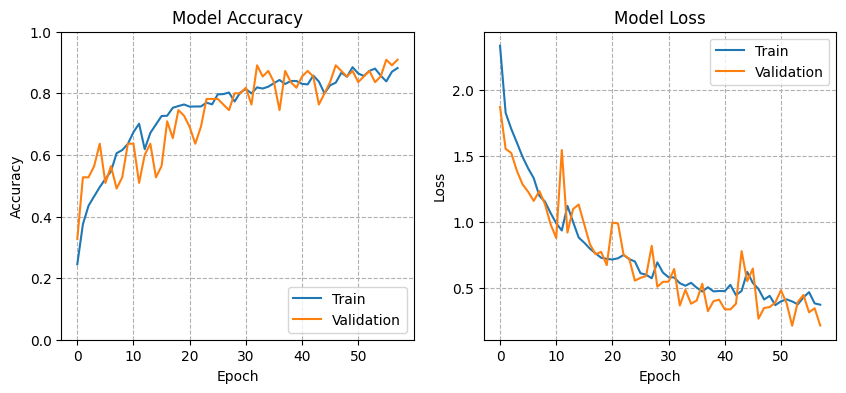

In [30]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.ylim(0,1)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [31]:
# Save Model to Google Drive
if SAVE_TO_DRIVE:
  model.save("amd_cnn_model")
  !zip -r -q /content/amd_cnn_model.zip /content/amd_cnn_model
  shutil.copy("/content/amd_cnn_model.zip","/content/drive/MyDrive/")


In [32]:
# Load Model from Google Drive
# !unzip -q /content/drive/MyDrive/amd_cnn_model.zip -d /
# model = tf.keras.models.load_model('./amd_cnn_model')

In [33]:
# Evaluate Performance on Test Dataset
results = model.evaluate(test_ds)
print("Loss: "+str(results[0])+" Accuracy: " + str(results[1]))

2/2 [==============================] - 0s 45ms/step - loss: 0.1079 - accuracy: 0.9818
Loss: 0.107878677546978 Accuracy: 0.9818181991577148


In [34]:
pred_test_labels = np.argmax(model.predict(test_ds), axis = 1)

2/2 [==============================] - 0s 19ms/step


In [35]:
true_test_labels = [CLASS_NAMES[label_int] for label_int in true_test_labels]
pred_test_labels = [CLASS_NAMES[label_int] for label_int in pred_test_labels]

In [36]:
report = classification_report(true_test_labels, pred_test_labels)
print(report)

                                  precision    recall  f1-score   support

Alstonia Scholaris healthy (P2b)       1.00      0.80      0.89         5
             Arjun healthy (P1b)       1.00      1.00      1.00         5
              Basil healthy (P8)       1.00      1.00      1.00         5
           Chinar healthy (P11a)       1.00      1.00      1.00         5
             Gauva healthy (P3a)       1.00      1.00      1.00         5
             Jamun healthy (P5a)       1.00      1.00      1.00         5
          Jatropha healthy (P6a)       1.00      1.00      1.00         5
            Lemon healthy (P10a)       1.00      1.00      1.00         5
             Mango healthy (P0a)       1.00      1.00      1.00         5
       Pomegranate healthy (P9a)       1.00      1.00      1.00         5
  Pongamia Pinnata healthy (P7a)       0.83      1.00      0.91         5

                        accuracy                           0.98        55
                       macro avg    

In [37]:
import pandas as pd

Text(0.5, 1.0, 'Healthy Leaves Classification Confusion Matrix')

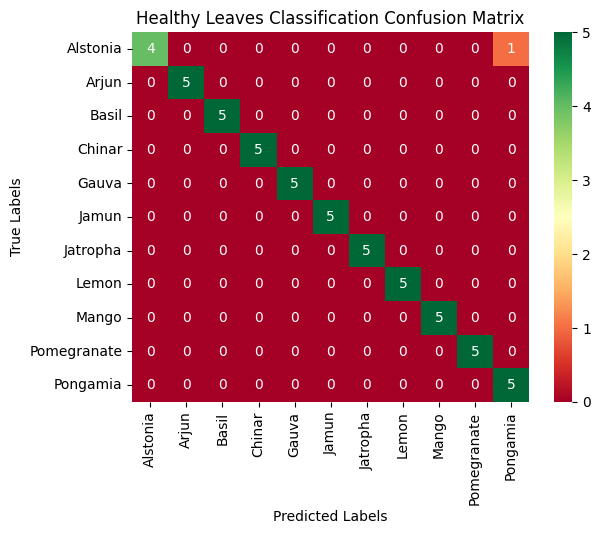

In [38]:
# Confusion Matrix
simple_class_names = [plant.split()[0] for plant in CLASS_NAMES]
heatmap = sns.heatmap(confusion_matrix(true_test_labels, pred_test_labels), 
                      xticklabels = simple_class_names, yticklabels = simple_class_names, 
                      annot = True, cmap='RdYlGn')
heatmap.set_ylabel("True Labels")
heatmap.set_xlabel("Predicted Labels")
heatmap.set_title("Healthy Leaves Classification Confusion Matrix")